In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [8]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
# DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'pca.h5')
sys.path.insert(0, PROJECT_PATH)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading Data

In [26]:
with h5py.File(PCA_PATH, 'r') as f:
#     flux = f['flux'][()]
#     flux_idx = f['flux_idx'][()]
#     Fe_H = f['Fe_H'][()]
#     log_g = f['log_g'][()]
#     O_M = f['O_M'][()]
#     C_M = f['C_M'][()]
#     T_eff = f['T_eff'][()]
    wave = f['wave'][()]
    eigv = f['flux_eigv'][()]


In [9]:
DATA_PATH = os.path.join(DATA_DIR, 'pc32.h5')
with h5py.File(DATA_PATH, 'r') as f:
    flux = f['flux'][()]
    flux32m = f['flux32m'][()]
    flux32ms = f['flux32ms'][()]

In [20]:
f_mean = np.mean(flux, axis=0)

In [92]:
f_mean.shape

(32,)

In [23]:
std = flux32m.std()

In [24]:
with h5py.File(DATA_PATH, 'a') as f:
    f.create_dataset('fmean', data = f_mean, shape = (32,))
    f.create_dataset('fm_std', data = std, shape = (1,))  

In [10]:
flux.shape

(116614, 32)

### LOADING MODEL

In [84]:
config_dict ={
    "data": {
      "dir":"./data",
      "filename": "pca.h5",
      "train": "flux32ms",
      "std_rate": 0.0
    },
    "model":{
      "aug": 1,
      "name": "t_act_",
      "input_dim": 32,
      "latent_dim": 8,
      "hidden_dims": [128, 32],
      "dropout": 0.0,
      "lr": 0.003,
      "reg1": 0.000001,
      "loss": "mse",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 20,
      "batch_size": 16,
      "validation_split":0.3,
      "verbose": 1
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
}
config = DotMap(config_dict)

In [14]:
#  loss: 0.0113 
# - mean_squared_error: 0.0023 
# - val_loss: 0.0337 
# - val_mean_squared_error: 0.0248

In [85]:
from ae.model.simple_ae_model import SimpleAEModel
from ae.trainer.simple_ae_trainer import SimpleAETrainer

In [86]:
mm = SimpleAEModel()
mm.build_model(config)

In [87]:
MODEL_PATH="/home/swei20/AE/trained_model/ep200_mse_lr2_32_l8_h128_h32_INleEMleHDle_pc32_ms0708_105250/"
# MODEL_PATH="/home/swei20/AE/trained_model/ep500_mse_lr2_32_l8_h128_h64_INleEMleHDle_pc32_0707_143841/"
mm.load(MODEL_PATH)

Loading model checkpoint /home/swei20/AE/trained_model/ep200_mse_lr2_32_l8_h128_h32_INleEMleHDle_pc32_ms0708_105250/ ...

Model loaded


In [89]:
data = flux32ms
tt = SimpleAETrainer(mm, config)
history = tt.train((data, data), ep=1)

5102/5102 [==============================] - 12s 2ms/step - loss: 6.0132e-04 - mean_squared_error: 4.6742e-04 - val_loss: 0.0102 - val_mean_squared_error: 0.0101


In [82]:
mm.model.history.history

{'loss': [0.012543224729597569],
 'mean_squared_error': [0.00046742006088607013],
 'val_loss': [0.05432097986340523],
 'val_mean_squared_error': [0.010054616257548332],
 'lr': [3.0000004e-17]}

In [90]:
tt.eval(eigv)

In [93]:
def get_org(x, std, mean):
    return x * std + mean

In [ ]:
tt1 = tt.x_train*  std +f_mean

In [98]:
np.sum((flux  - ae_pred_org)**2, axis=1).mean()

3.866500359358726

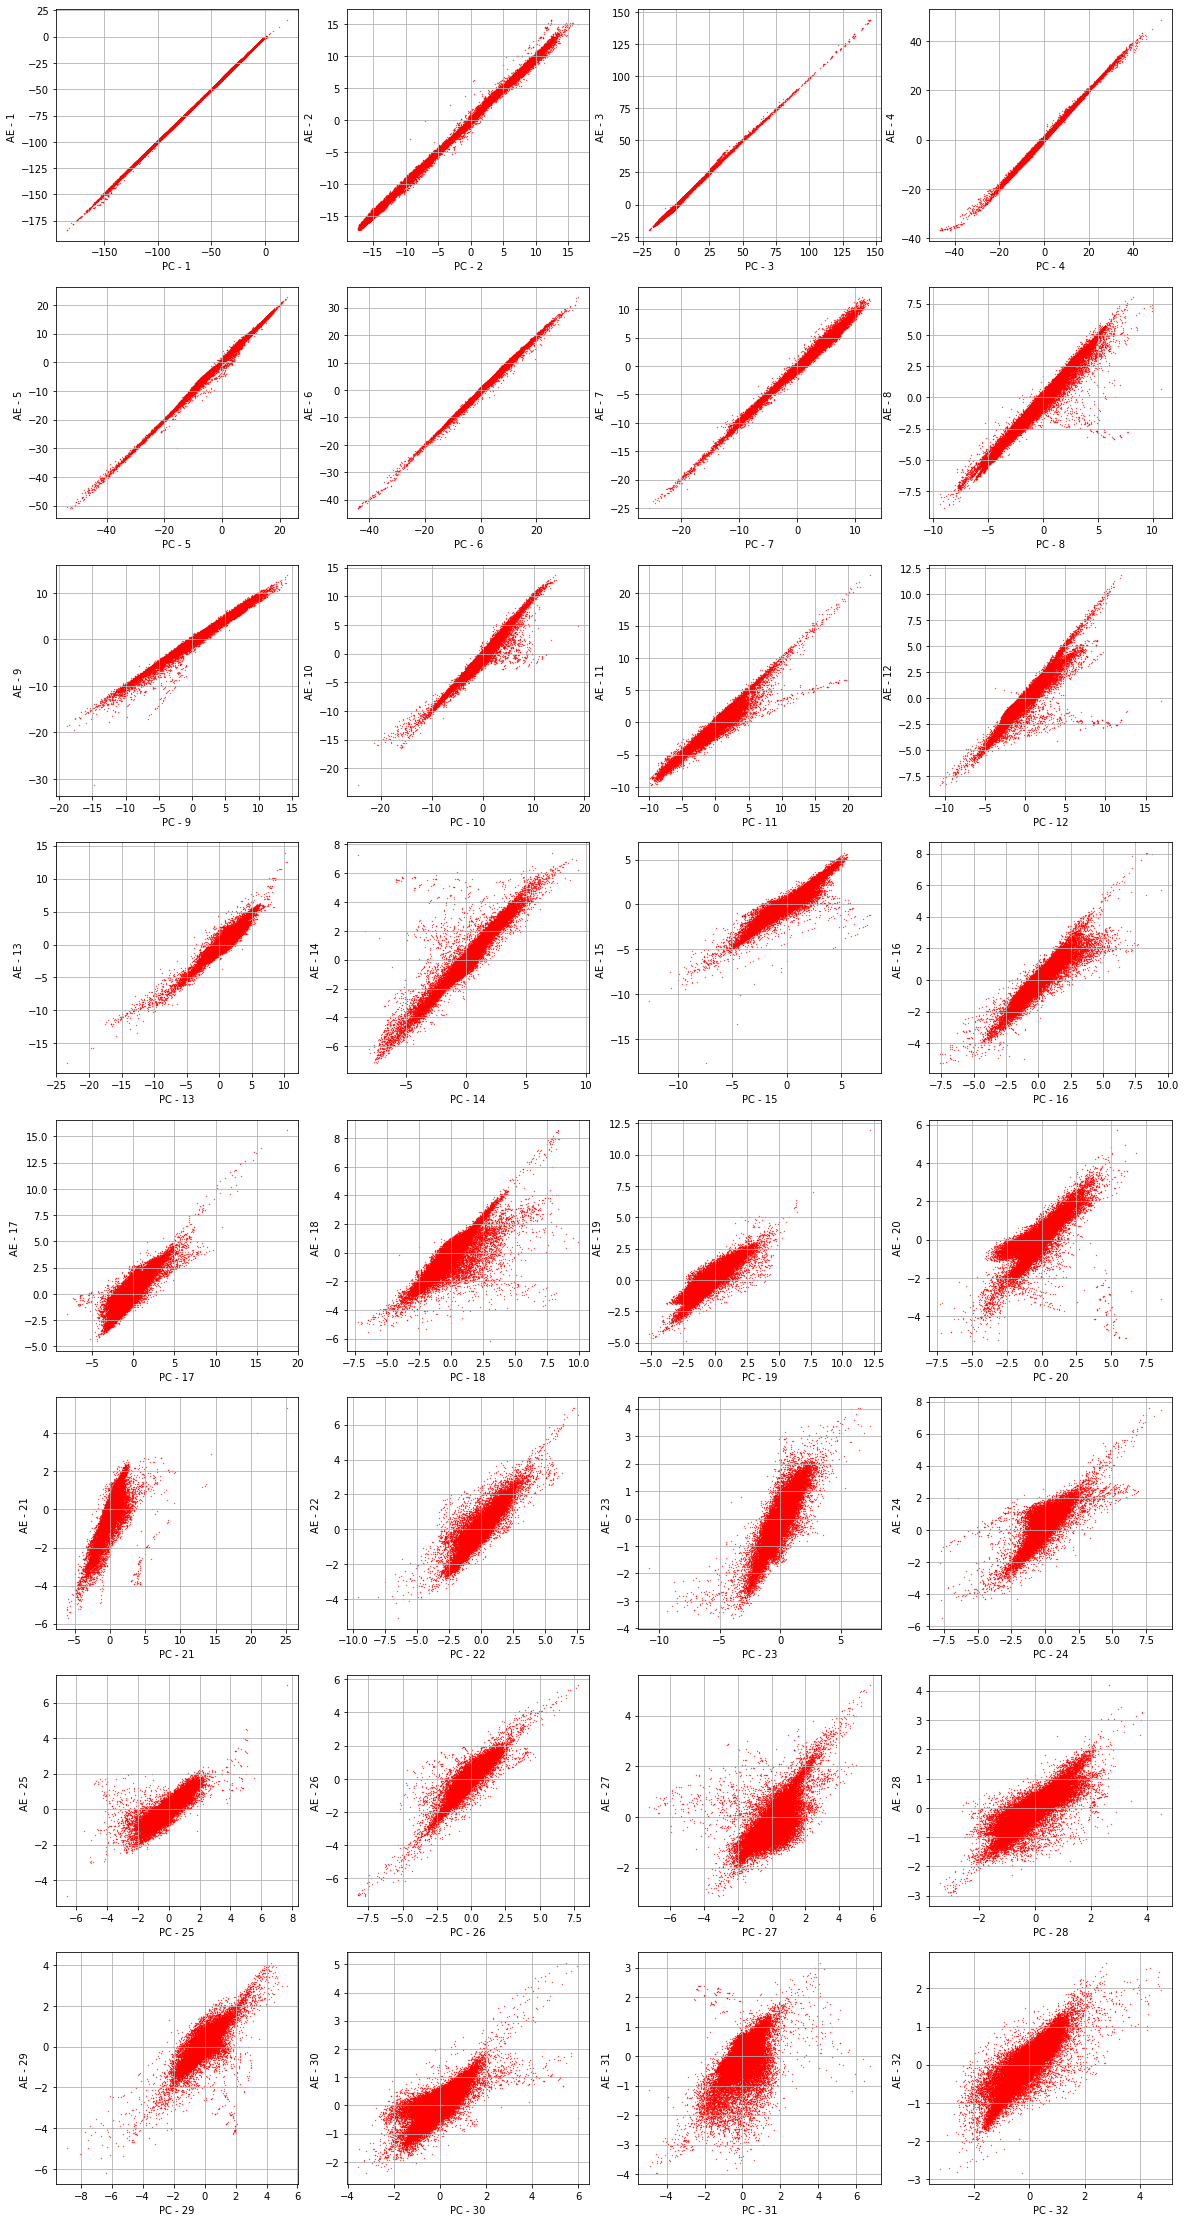

In [95]:
ae_pred_org = get_org(tt.ae_pred, std, f_mean)
plot_err(flux, ae_pred_org)

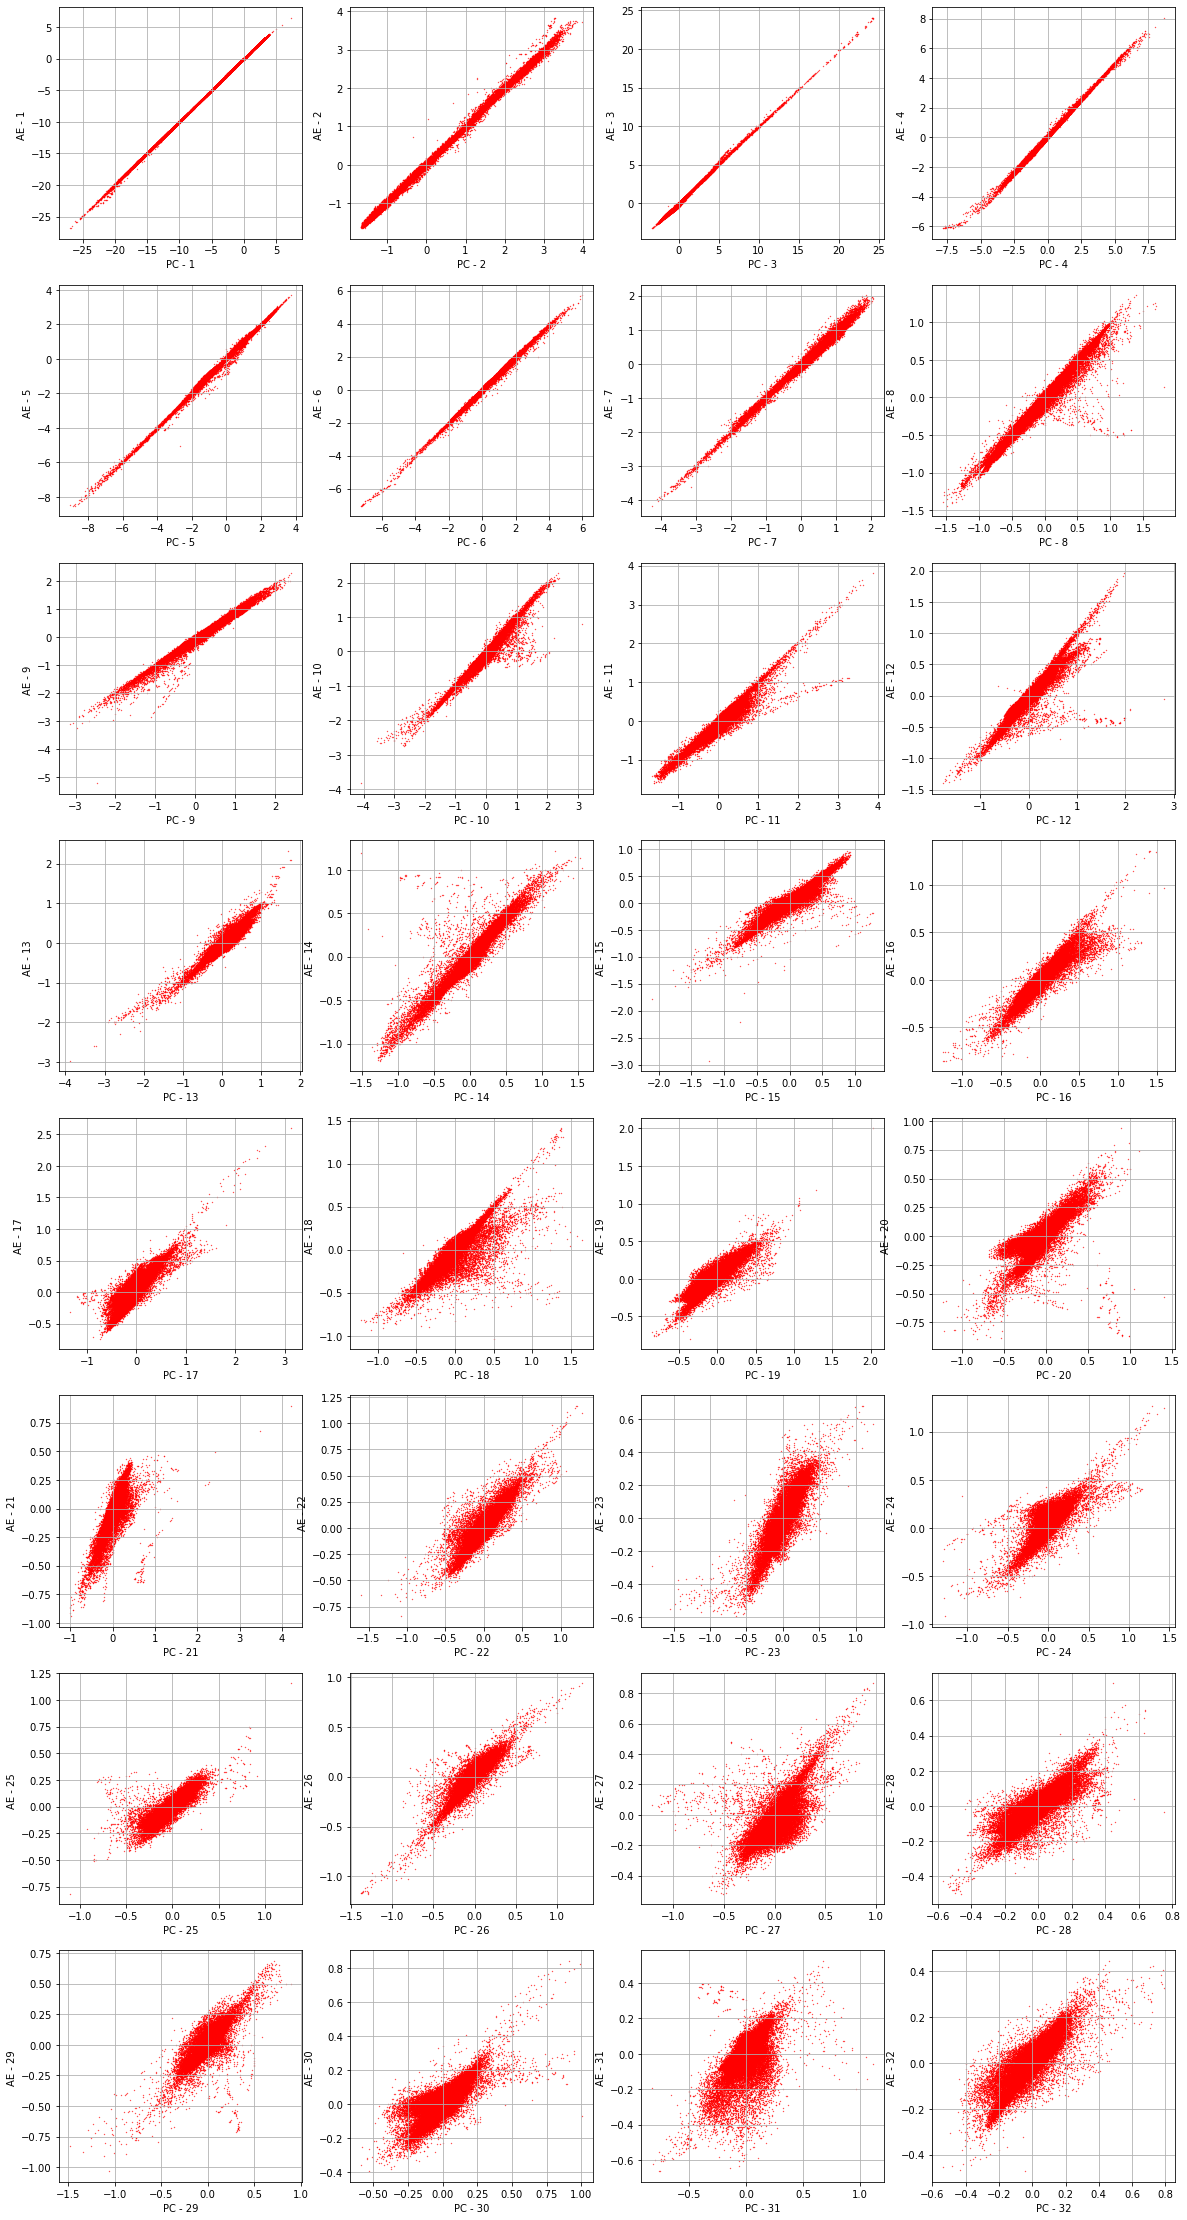

In [91]:
plot_err(tt.x_train, tt.ae_pred)

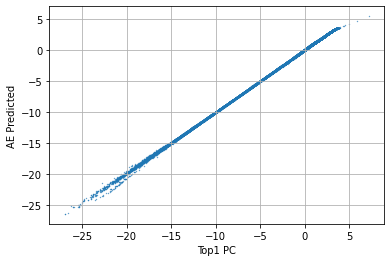

In [41]:
idx=0
plt.scatter(tt.x_train[:, idx],tt.ae_pred[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"Top{idx+1} PC")
plt.ylabel("AE Predicted")

# plt.legend()
plt.grid(1)

In [59]:
def plot_err(org, rec):
    f, axs =  plt.subplots(8, 4,figsize=(20, 40))
    for idx, ax in enumerate(axs.flatten()):
        ax.scatter(org[:, idx],rec[:, idx], s=0.1, color  = 'r')
        ax.set_xlabel(f"PC - {idx + 1}")
        ax.set_ylabel(f"AE - {idx + 1} ")
        ax.grid(1)

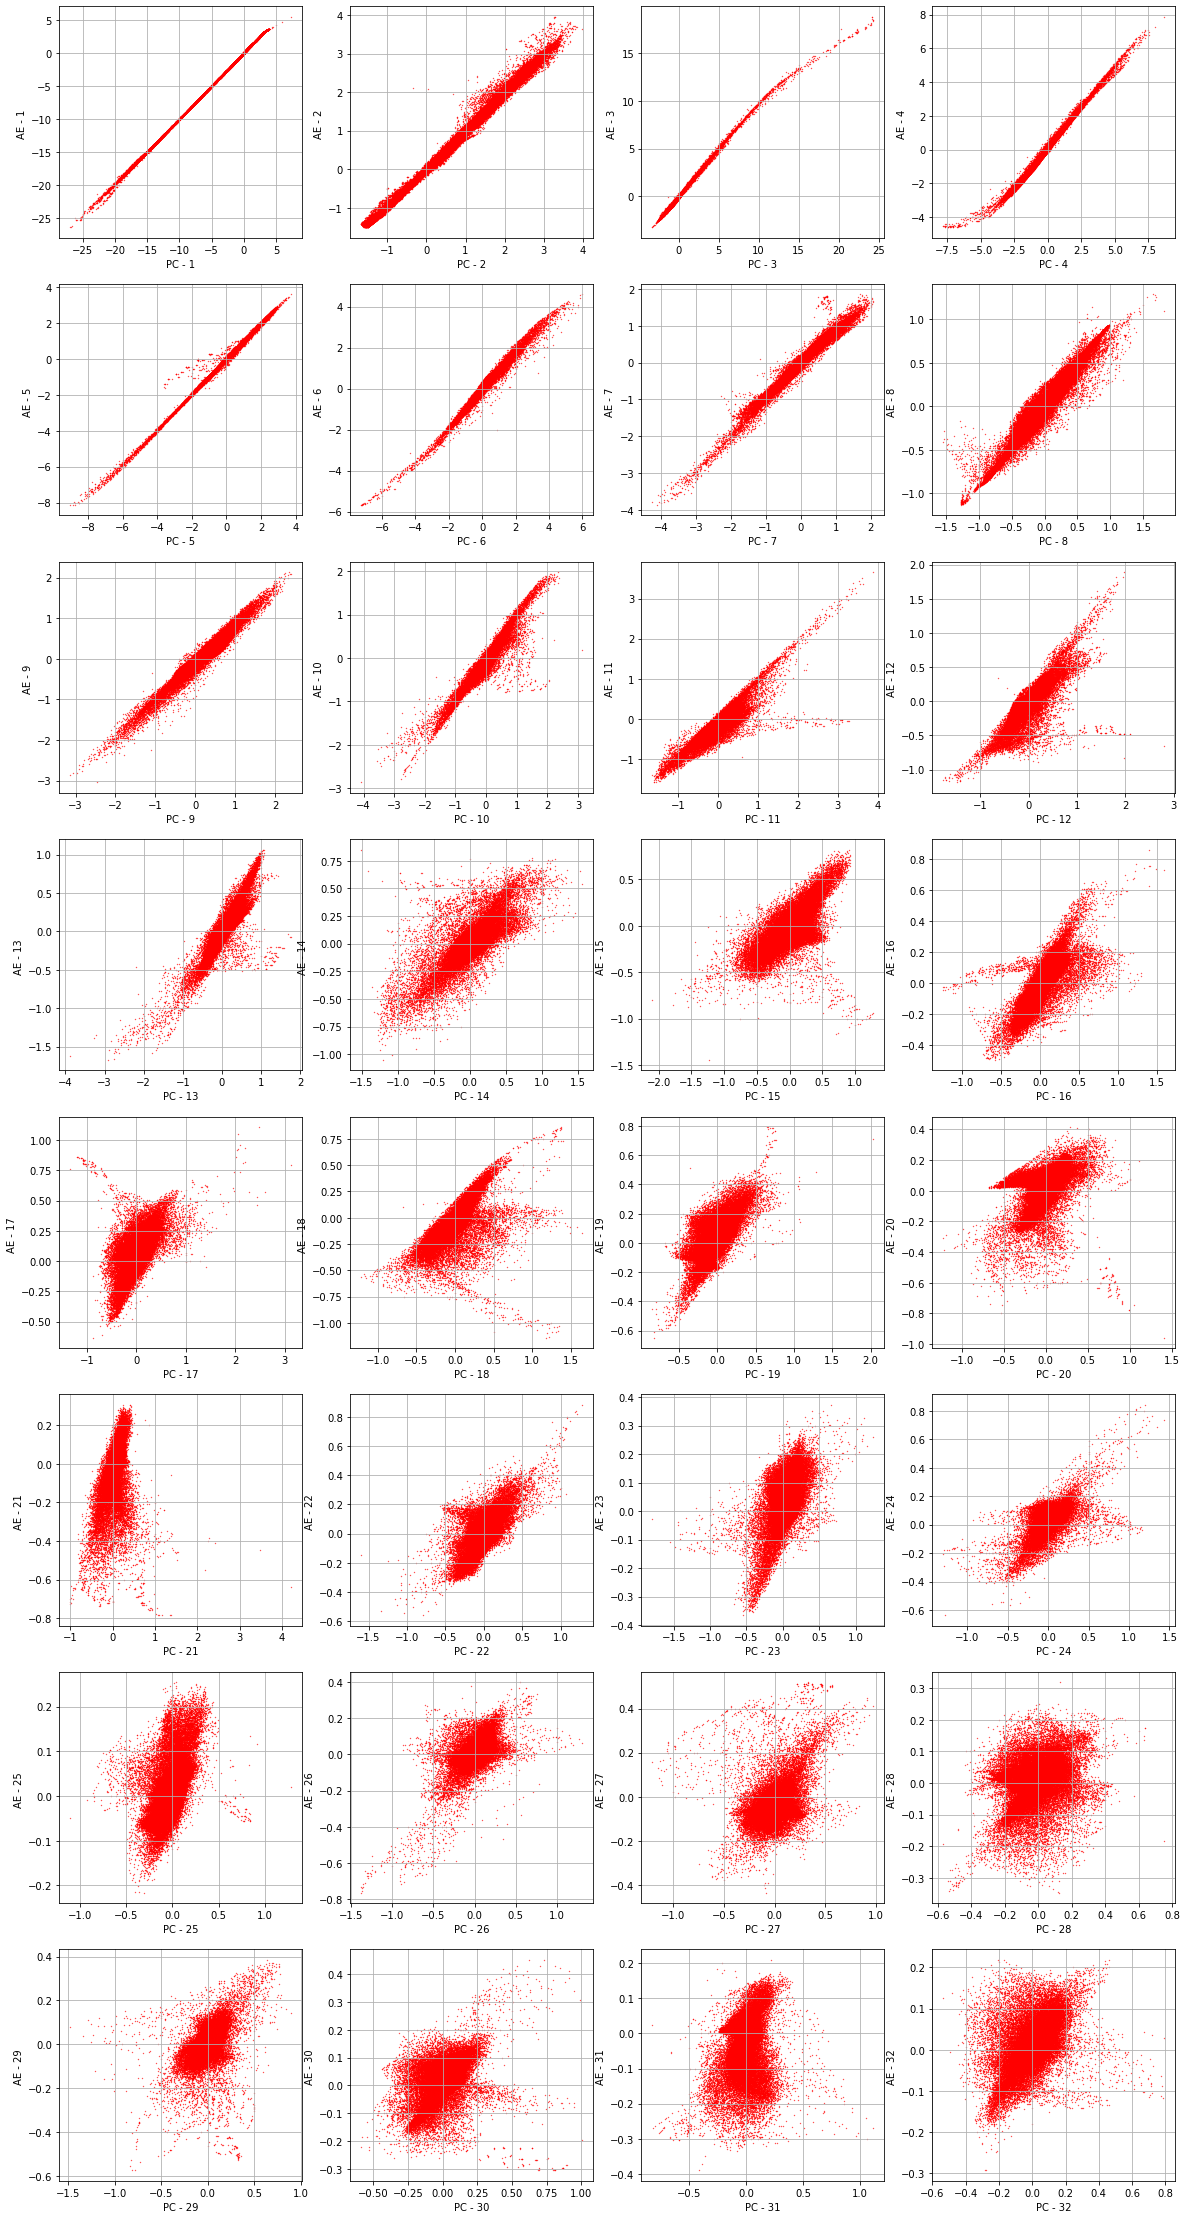

In [60]:
plot_err(tt.x_train, tt.ae_pred)

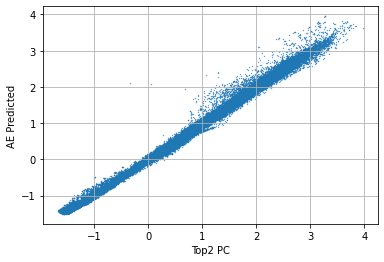

In [42]:
idx=1
plt.scatter(tt.x_train[:, idx],tt.ae_pred[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"PC - {idx + 1}")
plt.ylabel(f"AE - {idx + 1} "`)

# plt.legend()
plt.grid(1)

In [99]:
en32 = mm.encoder.predict(data)

In [103]:
s =np.linalg.svd(en32, compute_uv=False)

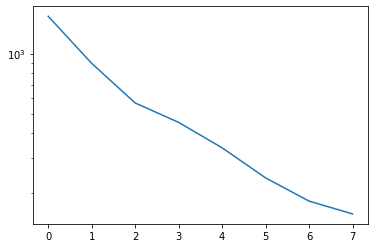

In [104]:
plt.plot( s )
# plt.xscale('log')
plt.yscale('log')